In [19]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
import seaborn as sns
import statsmodels.api as sm

/tmp/ipykernel_178234/1396264545.py:7: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr
/tmp/ipykernel_178234/1396264545.py:8: DeprecationWarning: Please import `spearmanr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import spearmanr


Error formatting dates: int too big to convert


/tmp/ipykernel_178234/175425597.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(i) for i in range(len(df))], rotation=45)


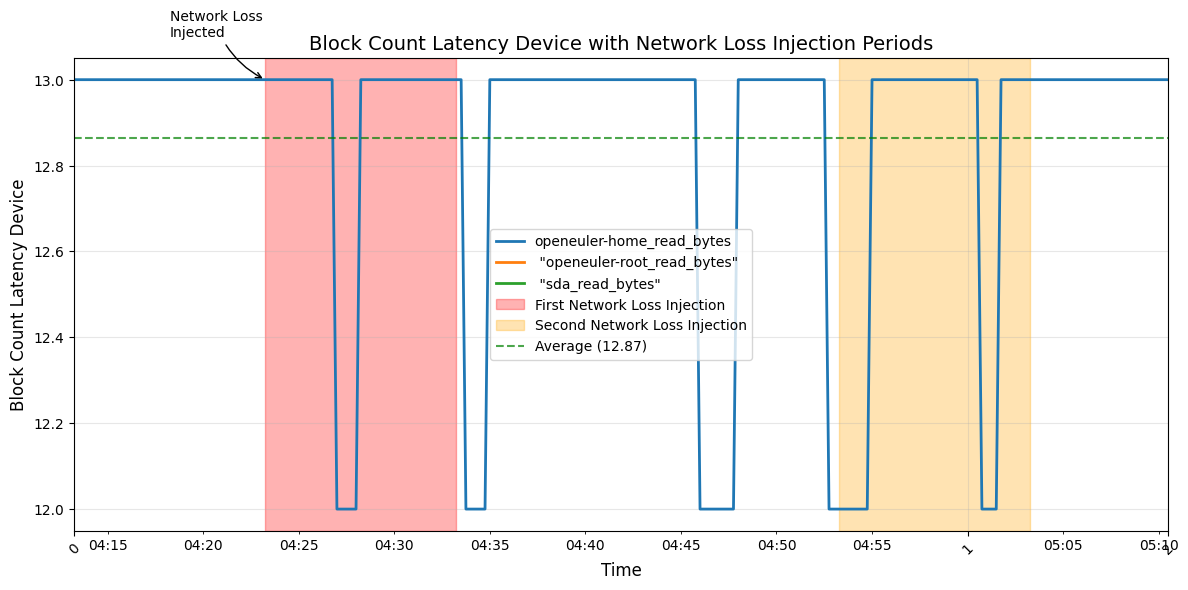

<Figure size 640x480 with 0 Axes>

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np

# Read the data
df = pd.read_csv('../datasets/block_count_latency_device.csv', parse_dates=['Time'], index_col='Time')

# Check for invalid dates and filter if necessary
min_valid_date = pd.Timestamp('0001-01-01')
max_valid_date = pd.Timestamp('9999-12-31')
valid_dates = (df.index >= min_valid_date) & (df.index <= max_valid_date)
if not all(valid_dates):
    print(f"Warning: Found {(~valid_dates).sum()} invalid dates. Filtering them out.")
    df = df[valid_dates]

# If the dataframe is empty after filtering, we need to debug
if df.empty:
    print("No valid data points after filtering. Check your date values.")
    print("Sample of original index values:")
    # Read without parsing dates to check raw values
    df_raw = pd.read_csv('../datasets/block_count_latency_device.csv')
    print(df_raw['Time'].head())
    raise ValueError("Unable to process dataset due to date conversion issues")

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
df.plot(ax=ax, linewidth=2)

# Get the test start time and calculate injection periods
# Try a safer approach
try:
    test_start_time = df.index[0]
    
    # Calculate the injection periods
    first_injection_start = test_start_time + timedelta(seconds=600)
    first_injection_end = first_injection_start + timedelta(seconds=600)
    second_injection_start = test_start_time + timedelta(seconds=2400)
    second_injection_end = second_injection_start + timedelta(seconds=600)
    
    # Add shaded regions for the injection periods
    ax.axvspan(first_injection_start, first_injection_end, alpha=0.3, color='red', 
               label='First Network Loss Injection')
    ax.axvspan(second_injection_start, second_injection_end, alpha=0.3, color='orange', 
               label='Second Network Loss Injection')
except (OverflowError, ValueError) as e:
    print(f"Error with date calculations: {e}")
    print("Skipping date-specific annotations")

# Adding a horizontal line at the average value for reference
avg_value = df.mean().iloc[0]
ax.axhline(y=avg_value, color='green', linestyle='--', alpha=0.7, 
           label=f'Average ({avg_value:.2f})')

# Improve the appearance
ax.set_title('Block Count Latency Device with Network Loss Injection Periods', fontsize=14)
ax.set_ylabel('Block Count Latency Device', fontsize=12)
ax.set_xlabel('Time', fontsize=12)
ax.grid(True, alpha=0.3)

# Format x-axis with a safer approach - this was causing the error
try:
    # Only use DateFormatter if dates are within valid range
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(rotation=45)
except (OverflowError, ValueError) as e:
    print(f"Error formatting dates: {e}")
    # Fall back to simple integer indexing
    ax.set_xticklabels([str(i) for i in range(len(df))], rotation=45)

# Add legend
ax.legend(loc='best')

# Add annotations - only if date calculations worked
try:
    y_max = df.max().iloc[0]
    ax.annotate('Network Loss\nInjected', xy=(first_injection_start, y_max), 
                xytext=(first_injection_start - timedelta(minutes=5), y_max + 0.1),
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
except (NameError, OverflowError, ValueError) as e:
    print(f"Error adding annotations: {e}")
    print("Skipping annotations")

# Tight layout
plt.tight_layout()

# Show the plot
plt.show()

# Save the figure
try:
    plt.savefig('block_count_latency_with_injections.png', dpi=300, bbox_inches='tight')
except Exception as e:
    print(f"Error saving figure: {e}")
    # Try alternative approach
    plt.savefig('block_count_latency_basic.png', dpi=300)

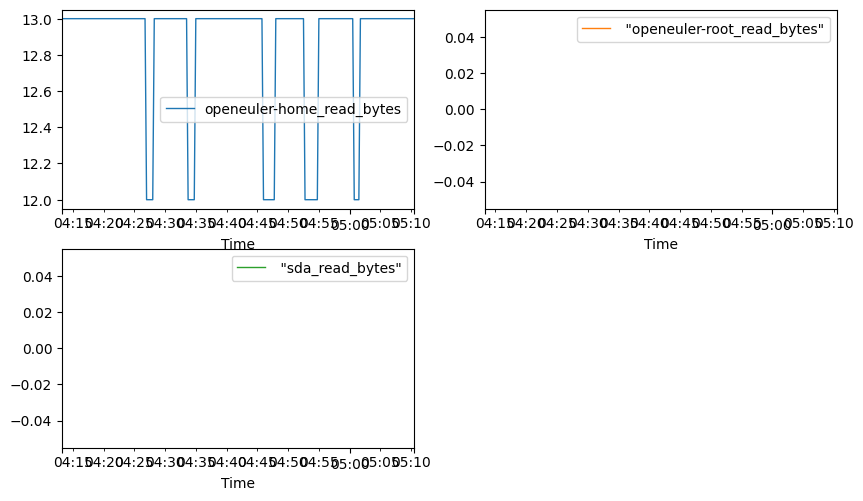

In [21]:
df.plot(subplots=True,
        linewidth=1,
        layout=(5,2),
        figsize=(10,15),
        sharex=False,
        sharey=False)
plt.show()

/tmp/ipykernel_178234/636100573.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current += x[i]
/tmp/ipykernel_178234/636100573.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current -= x[i-order]


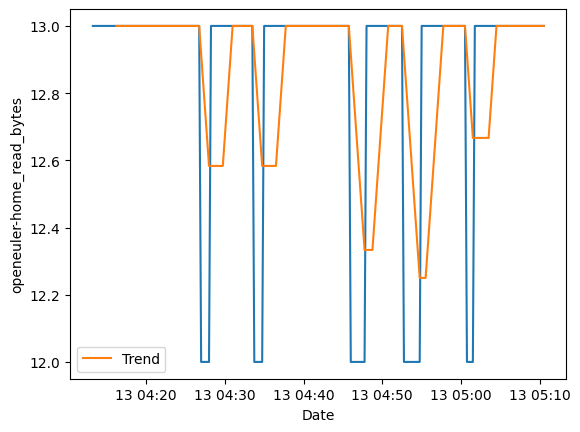

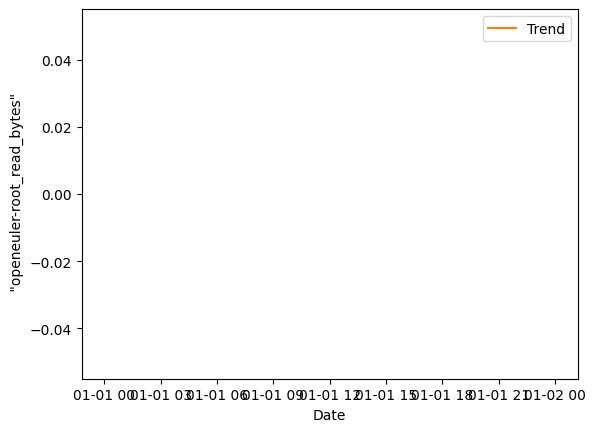

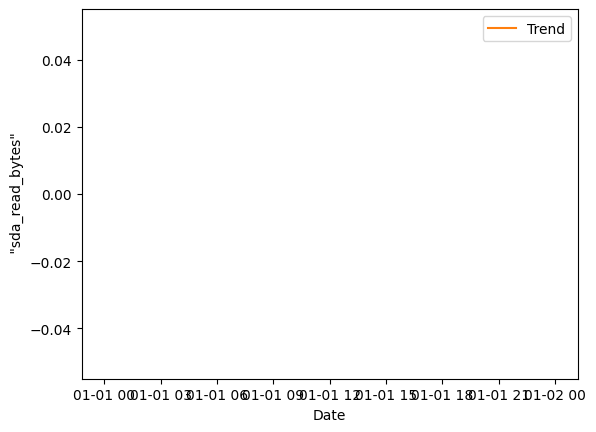

In [22]:
def running_average(x, order):
    current = x[:order].sum()
    running = []

    for i in range(order, x.shape[0]):
        current += x[i]
        current -= x[i-order]
        running.append(current/order)
    
    return np.array(running)

for feature in df.columns:
    trend = running_average(df[feature], 12)
    fig, ax = plt.subplots(1, 1)
    ax.plot(df.index, df[feature])
    ax.set_xlabel('Date')
    ax.set_ylabel(feature)
    ax.plot(df.index[12:], trend, label='Trend')
    ax.legend()

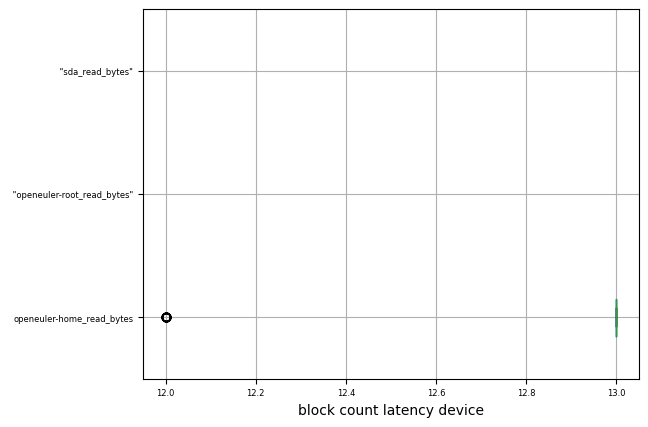

In [23]:
ax = df.boxplot(fontsize=6, vert=False)
ax.set_xlabel('block count latency device')
plt.show()

In [24]:
# Pearson correlation matrix
corr_p = df[df.columns].corr(method='pearson')
print('\nPearson correlation matrix')
print(corr_p)

# Spearman correlation matrix'
corr_s = df[df.columns].corr(method='spearman')
print('\nSpearman correlation matrix')
print(corr_s)


Pearson correlation matrix
                              openeuler-home_read_bytes  \
openeuler-home_read_bytes                           1.0   
 "openeuler-root_read_bytes"                        NaN   
 "sda_read_bytes"                                   NaN   

                               "openeuler-root_read_bytes"   "sda_read_bytes"  
openeuler-home_read_bytes                              NaN                NaN  
 "openeuler-root_read_bytes"                           NaN                NaN  
 "sda_read_bytes"                                      NaN                NaN  

Spearman correlation matrix
                              openeuler-home_read_bytes  \
openeuler-home_read_bytes                           1.0   
 "openeuler-root_read_bytes"                        NaN   
 "sda_read_bytes"                                   NaN   

                               "openeuler-root_read_bytes"   "sda_read_bytes"  
openeuler-home_read_bytes                              NaN           

<Axes: >

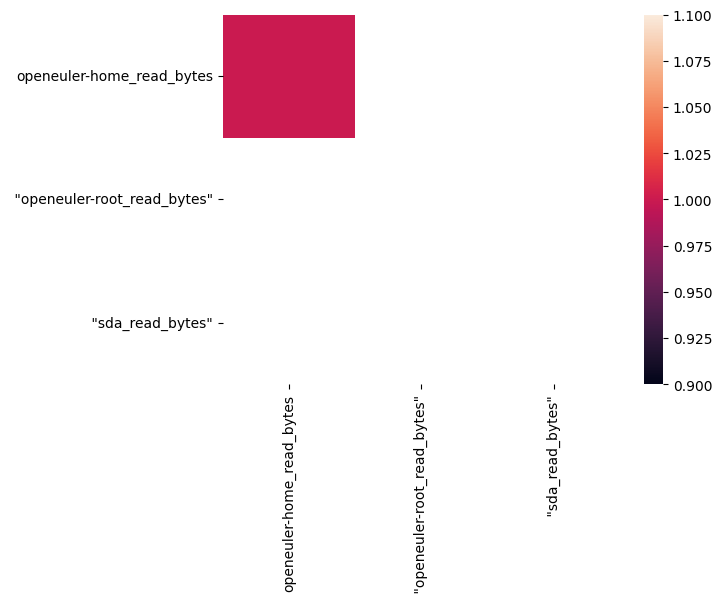

In [25]:
corr_mat = df.corr(method='pearson')
sns.heatmap(corr_mat)

<Axes: >

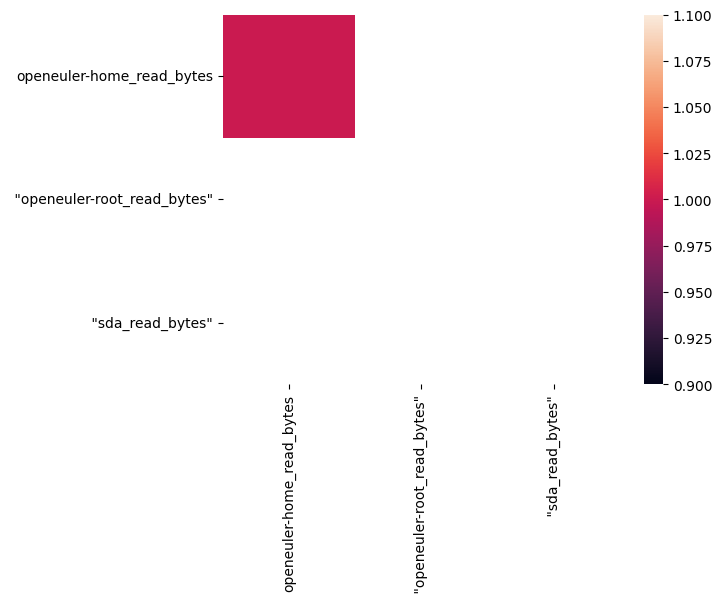

In [26]:
corr_mat_spearman = df.corr(method='spearman')
sns.heatmap(corr_mat_spearman)

In [27]:
dict_decompositions = {}
df.names = df.columns
print(df.names)


Index(['openeuler-home_read_bytes', ' "openeuler-root_read_bytes"',
       ' "sda_read_bytes"'],
      dtype='object')


/tmp/ipykernel_178234/2198433391.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.names = df.columns


In [28]:
for feature in df.names:
    feature_decomposition = sm.tsa.seasonal_decompose(df[feature], period=43)
    dict_decompositions[feature] = feature_decomposition

dict_trend = {}
dict_seasonal = {}
dict_resid = {}

for feature in df.names:
    dict_trend[feature] = dict_decompositions[feature].trend  #TODo Check the period and where to insert!
    dict_seasonal[feature] = dict_decompositions[feature].seasonal
    dict_resid[feature] = dict_decompositions[feature].resid

trend_df = pd.DataFrame.from_dict(dict_trend)
seasonal_df = pd.DataFrame.from_dict(dict_seasonal)
resid_df = pd.DataFrame.from_dict(dict_resid)

ValueError: This function does not handle missing values

In [ ]:
trend_df.plot(
    subplots=True,
    layout=(5,2),
    figsize=(17,10),
    sharex=True,
    sharey=False
)
plt.title('trend component of block count latency device dataset')

In [ ]:
resid_df.plot(
    subplots=True,
    layout=(5,2),
    figsize=(17,10),
    sharex=True,
    sharey=False
)
plt.title('residual component of block count latency device dataset')

In [ ]:
trend_df.plot()
plt.title('trend of the feature in the dataset')

seasonal_df.plot()
plt.title('seasonal of the feature in the dataset')

resid_df.plot()
plt.title('residual of the feature in the dataset')

In [ ]:


trend_corr = trend_df.corr(method='pearson')

# Customize the clustermap of the seasonality_corr
fig = sns.clustermap(trend_corr, annot=True, linewidth=0.5,figsize=(9,7))

plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)

In [ ]:
trend_corr_spearman = trend_df.corr(method='spearman')

fig = sns.clustermap(trend_corr, annot=True, linewidth=0.4,figsize=(9,7))

plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)